In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry
import numpy as np
from copy import copy
import matplotlib.pyplot as plt

# 1) Mesh

In [2]:
geo = SplineGeometry()

geo.AddRectangle(p1=(-3,-3),p2=(3,3),bc="rectangle",leftdomain=1,rightdomain=0,
                 bcs = ("right", "top", "left", "bot"))

geo.AddRectangle(p1=(-1,-0.4), p2=(1,0.4),bc="rectangle",leftdomain=2,rightdomain=1)

geo.SetMaterial (1, "out")
geo.SetMaterial (2, "in")

ngmesh = geo.GenerateMesh(maxh=0.2)
mesh = Mesh(ngmesh)
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

## Méthode 1 : moindre carrés

Étant donné un champ $v \in \mathcal{L}^2(\Omega)$ (défini aux points de Gauss), on veut trouver un champ $u\in\mathcal{H}^1(\Omega)$ (défini aux noeuds) en résolvant :
$$\forall \theta^*\in \mathcal{H}^1(\Omega), \quad \int_\Omega \theta^* u = \int_\Omega \theta^* v  $$

In [3]:
fes_noeuds = H1(mesh)
fes_gauss = L2(mesh)

v = GridFunction(fes_gauss)
#v.Set(3*x+y**2) 
v.Set(1, definedon = mesh.Materials("in"))

theta = fes_noeuds.TestFunction()
u = fes_noeuds.TrialFunction()

K = BilinearForm(fes_noeuds, symmetric = True)
K += theta*u*dx

l = LinearForm(fes_noeuds)
l += theta * v *dx

l.Assemble()
K.Assemble()
    
usol = GridFunction(fes_noeuds)  # solution
usol.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l.vec

In [4]:
Draw(v,mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [5]:
Draw(usol,mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

## Méthode 2 : décomposition de Helmoltz-Hodge

Ce théorème dit, en gros, que tout champ vectoriel $\mathcal{L}^2(\Omega)$ peut se décomposer de la manière suivante :

$$ \vec{u} = \nabla \theta + \nabla \times \vec{\phi} $$

avec $\theta \in \mathcal{H}^1(\Omega)$ (facile à interpoler) et $\vec{\phi} \in H(\text{curl},\Omega)$. On peut alors calculer $\theta$ facilement par 

$$\forall \theta^*\in \mathcal{H}^1(\Omega), \quad \int_\Omega \nabla \theta^* \cdot \nabla \theta = \int_\Omega \nabla\theta^* \cdot \vec{u} $$

en imposant $\theta = 0$ en un point arbitraire, puis $\vec{\phi}$ en résolvant :
$$\forall \vec{\phi}^*\in H(\text{curl},\Omega), \quad \int_\Omega \nabla \times \vec{\phi}^* \cdot \nabla \times \vec{\phi}  = \int_\Omega \nabla \times \vec{\phi}^*\cdot (\vec{u} - \nabla \theta) $$

Ce calcul exige une jauge (ou bien d'être résolu par un gradient conjugué). Si on ne veut pas s'embêter, on peut ajouter un terme de pénalisation : 
$$\forall \vec{\phi}^*\in H(\text{curl},\Omega), \quad \int_\Omega \nabla \times \vec{\phi}^* \cdot \nabla \times \vec{\phi} + \epsilon  \int_\Omega \vec{\phi}^* \cdot \vec{\phi} = \int_\Omega \nabla \times \vec{\phi}^*\cdot (\vec{u} - \nabla \theta) $$

Par ailleurs, $\vec{\phi}$ est plus dur à interpoler : il faudrait interpoler non pas les valeurs du champ mais les valeurs des circulations aux arêtes du nouveau maillage). En 2D en revanche, l'opérateur rotationnel s'écrit :

$$ \nabla  \times \vec{\phi} = \left[ \begin{matrix} 0 & 1 \\ -1 & 0 \end{matrix} \right] \nabla \phi_z $$

Avec $\phi_z$ une grandeur nodale facilement interpolable

In [6]:
# définition de la fonction à décomposer
vec = GridFunction(L2(mesh, dim = 2))
vec.Set(CoefficientFunction((1,1)), definedon = mesh.Materials("in"))

Draw(vec,mesh,vectors = { "grid_size":20})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [7]:
# composante coulombienne
fes_noeuds2 = H1(mesh)
fes_noeuds2.FreeDofs()[0] = False

theta_star = fes_noeuds2.TestFunction()
theta = fes_noeuds2.TrialFunction()

Kgrad = BilinearForm(fes_noeuds2, symmetric = True); Kgrad += grad(theta_star)*grad(theta)*dx
lgrad = LinearForm(fes_noeuds2) ;lgrad += grad(theta_star) * vec *dx
lgrad.Assemble() ; Kgrad.Assemble()
thetaSol = GridFunction(fes_noeuds2)  # solution
thetaSol.vec.data =     Kgrad.mat.Inverse(inverse="sparsecholesky",freedofs  =fes_noeuds2.FreeDofs() ) * lgrad.vec

Draw(grad(thetaSol),mesh,vectors = { "grid_size":20})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [8]:
# composante solenoidale

def Rot2d(field):
    return CoefficientFunction(((0,1),(-1,0)),dims = (2,2))*grad(field)

phi_star = fes_noeuds2.TestFunction()
phi = fes_noeuds2.TrialFunction()

Kcurl = BilinearForm(fes_noeuds2, symmetric = True); Kcurl += Rot2d(phi_star)*Rot2d(phi)*dx
lcurl = LinearForm(fes_noeuds2) ; lcurl += Rot2d(phi_star)* (vec - grad(thetaSol)) *dx
lcurl.Assemble() ; Kcurl.Assemble()
phiSol = GridFunction(fes_noeuds2)  # solution
phiSol.vec.data =     Kcurl.mat.Inverse(inverse="sparsecholesky",freedofs  =fes_noeuds2.FreeDofs() ) * lcurl.vec

Draw(Rot2d(phiSol),mesh,vectors = { "grid_size":20})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [9]:
Draw(grad(thetaSol) + Rot2d(phiSol),mesh,vectors = { "grid_size":20})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

# Étude de convergence

## 1) Champ "smooth"

In [10]:
errorDiffC0 = []
errorHelmoltzC0 = []
maxHC0 = []
for i in range(1,40,2):
    maxHC0.append(10**(-i*0.05))
    ngmesh = geo.GenerateMesh(maxh=maxHC0[-1])
    mesh = Mesh(ngmesh)
    
    # fonction aux "points de Gauss"
    vec = GridFunction(L2(mesh, dim = 2)) # espace L2 = défini aux points de Gauss
    vec.Set((x**2+1,-y**3))
    
    # Méthode moindre carrés = "diffusion"
    fes_noeuds = H1(mesh)
    theta_star = fes_noeuds.TestFunction()
    theta = fes_noeuds.TrialFunction()
    K = BilinearForm(fes_noeuds, symmetric = True) ; K += theta_star * theta *dx; K.Assemble()
    l0 = LinearForm(fes_noeuds); l0 += theta_star * vec[0] *dx;  l0.Assemble()
    l1 = LinearForm(fes_noeuds); l1 += theta_star * vec[1] *dx;  l1.Assemble()
    udiff0 = GridFunction(fes_noeuds)  # solution
    udiff0.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l0.vec
    udiff1 = GridFunction(fes_noeuds)
    udiff1.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l1.vec
    udiff =  GridFunction(H1(mesh, dim=2))
    udiff.Set((udiff0,udiff1))
    errorDiffC0.append(np.sqrt(Integrate((udiff-vec)*(udiff-vec),mesh)))
    
    # Méthode basée sur la décomposition de Helmoltz
    fes_noeuds_Helmoltz = H1(mesh)
    fes_noeuds_Helmoltz.FreeDofs()[0] = False
    
    # Composante gradient
    theta_star = fes_noeuds_Helmoltz.TestFunction()
    theta = fes_noeuds_Helmoltz.TrialFunction()

    KGrad = BilinearForm(fes_noeuds_Helmoltz, symmetric = True); KGrad += grad(theta_star)*grad(theta)*dx;  KGrad.Assemble()
    lGrad = LinearForm(fes_noeuds_Helmoltz) ;lGrad += grad(theta_star)* vec *dx; lGrad.Assemble()
    uGrad = GridFunction(fes_noeuds_Helmoltz)  # solution
    uGrad.vec.data =     KGrad.mat.Inverse(inverse="sparsecholesky",freedofs  =fes_noeuds_Helmoltz.FreeDofs()) * lGrad.vec
    
    # Composante rotationnel
    KRot = BilinearForm(fes_noeuds_Helmoltz, symmetric = True); KRot += Rot2d(theta_star)*Rot2d(theta)*dx;  KRot.Assemble()
    lRot = LinearForm(fes_noeuds_Helmoltz) ;lRot += Rot2d(theta_star)* (vec - grad(uGrad)) *dx; lRot.Assemble()
    uRot = GridFunction(fes_noeuds_Helmoltz)  # solution
    uRot.vec.data =     KRot.mat.Inverse(inverse="sparsecholesky",freedofs  =fes_noeuds_Helmoltz.FreeDofs()) * lRot.vec
    
    uHelmoltz = grad(uGrad) + Rot2d(uRot)
    errorHelmoltzC0.append(np.sqrt(Integrate((uHelmoltz-vec)*(uHelmoltz-vec),mesh)))
    
    print(i)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39


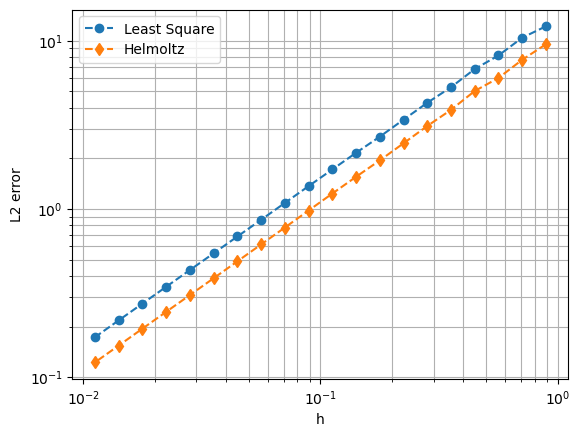

In [11]:
plt.loglog(maxHC0,errorDiffC0,'o--',label='Least Square')
plt.loglog(maxHC0,errorHelmoltzC0,'d--',label='Helmoltz')
plt.xlabel('h')
plt.ylabel('L2 error')
plt.grid(visible=1, which='both')
plt.legend()
plt.show()

## 2) Champ discontinu

In [12]:
errorDiff = []
errorHelmoltz = []
maxH = []
for i in range(1,40,2):
    maxH.append(10**(-i*0.05))
    ngmesh = geo.GenerateMesh(maxh=maxH[-1])
    mesh = Mesh(ngmesh)
    
    # fonction aux "points de Gauss"
    vec = GridFunction(L2(mesh, dim = 2)) # espace L2 = défini aux points de Gauss
    vec.Set(CoefficientFunction((1,1)), definedon = mesh.Materials("in"))
    
    # Méthode moindre carrés = "diffusion"
    fes_noeuds = H1(mesh)
    theta_star = fes_noeuds.TestFunction()
    theta = fes_noeuds.TrialFunction()
    K = BilinearForm(fes_noeuds, symmetric = True) ; K += theta_star * theta *dx; K.Assemble()
    l0 = LinearForm(fes_noeuds); l0 += theta_star * vec[0] *dx;  l0.Assemble()
    l1 = LinearForm(fes_noeuds); l1 += theta_star * vec[1] *dx;  l1.Assemble()
    udiff0 = GridFunction(fes_noeuds)  # solution
    udiff0.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l0.vec
    udiff1 = GridFunction(fes_noeuds)
    udiff1.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l1.vec
    udiff =  GridFunction(H1(mesh, dim=2))
    udiff.Set((udiff0,udiff1))
    errorDiff.append(np.sqrt(Integrate((udiff-vec)*(udiff-vec),mesh)))
    
    # Méthode basée sur la décomposition de Helmoltz
    fes_noeuds_Helmoltz = H1(mesh)
    fes_noeuds_Helmoltz.FreeDofs()[0] = False
    
    # Composante gradient
    theta_star = fes_noeuds_Helmoltz.TestFunction()
    theta = fes_noeuds_Helmoltz.TrialFunction()

    KGrad = BilinearForm(fes_noeuds_Helmoltz, symmetric = True); KGrad += grad(theta_star)*grad(theta)*dx;  KGrad.Assemble()
    lGrad = LinearForm(fes_noeuds_Helmoltz) ;lGrad += grad(theta_star)* vec *dx; lGrad.Assemble()
    uGrad = GridFunction(fes_noeuds_Helmoltz)  # solution
    uGrad.vec.data =     KGrad.mat.Inverse(inverse="sparsecholesky",freedofs  =fes_noeuds_Helmoltz.FreeDofs()) * lGrad.vec
    
    # Composante rotationnel
    KRot = BilinearForm(fes_noeuds_Helmoltz, symmetric = True); KRot += Rot2d(theta_star)*Rot2d(theta)*dx;  KRot.Assemble()
    lRot = LinearForm(fes_noeuds_Helmoltz) ;lRot += Rot2d(theta_star)* (vec - grad(uGrad)) *dx; lRot.Assemble()
    uRot = GridFunction(fes_noeuds_Helmoltz)  # solution
    uRot.vec.data =     KRot.mat.Inverse(inverse="sparsecholesky",freedofs  =fes_noeuds_Helmoltz.FreeDofs()) * lRot.vec
    
    uHelmoltz = grad(uGrad) + Rot2d(uRot)
    errorHelmoltz.append(np.sqrt(Integrate((uHelmoltz-vec)*(uHelmoltz-vec),mesh)))
    
    print(i)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39


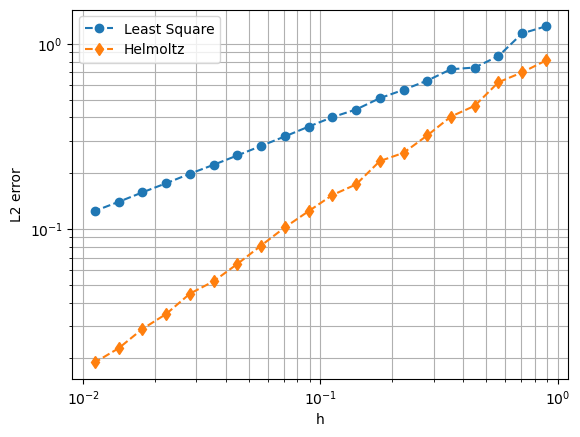

In [13]:
plt.loglog(maxH,errorDiff,'o--',label='Least Square')
plt.loglog(maxH,errorHelmoltz,'d--',label='Helmoltz')
plt.xlabel('h')
plt.ylabel('L2 error')
plt.grid(visible=1, which='both')
plt.legend()
plt.show()

# Référence:

- Thèse Antoine LEMOINE : "Décomposition de Hodge-Helmholtz discrète", Université de Bordeaux, 2014